In [1]:
import itertools
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
from math import *
import scipy
from tqdm import tqdm

from utils import *

import matplotlib as mpl
import seaborn as sns
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 16

In [2]:
# iterative solver of a community with lags using the lienar algebra method. 
# (current vers only apply to diauxic species)

In [3]:
# what resource is the species eating
def resource_eating(pref_list, dep_order):
    N, R = pref_list.shape[0], pref_list.shape[1]
    RE = np.zeros([N, R], dtype=np.int32)
    for i_n in range(N):
        for i_t in range(R):
            for i in range(R):
                top_resource = pref_list[i_n][i]
                if(top_resource in dep_order[i_t:]):
                    RE[i_n, i_t] = top_resource
                    break
    return RE

#def a state matrix
def niche_growth_state(RE, taus, t_order):
    N, R = taus.shape[0], taus.shape[1]
    # here we define a niche growth state matrix S, whose elements can be 0, 1, or 2
    # 0 means no growth; 1 means growth during full niche; 2 means part of of niche is taken by lag
    # and define a tau_mod - the lag time in each niche for those 2 elements in S. 
    S = np.ones([N, R])
    tau_mod = np.zeros([N, R])
    for species in range(N):
        # check the behavior between rsi-th t-niche and rei-th t-niche
        # which starts from 1 (second t-niche),
        # because we assume sum(t-niche)<<T, which means the lag in first t-niche is due to recovering from dormancy,
        # and we assume them to be species- and resource- independent. 
        res_last = 0 
        in_lagphase = 0
        tau_new = 0
        for niche in np.arange(1, R):
            # if next time niche is a different resource, 
            # we assume the species would renew the current lag by the lagtime of
            # switching from the previous (actively consuming) nutrient to the current nutrient
            # regardless of whether it was already in the middle of a lag phase or not. 
            if(RE[species][niche]!=RE[species][niche-1]): 
                tau_new = taus[species, RE[species][res_last]-1, RE[species][niche]-1]
                if(tau_new < t_order[niche]):
                    S[species, niche] = 2
                    tau_mod[species, niche] = tau_new
                    res_last = niche
                    in_lagphase = 0
                else:
                    S[species, niche] = 0
                    tau_new -= max(0, t_order[niche])
                    in_lagphase = 1
            # if the next time niche is a same resource, 
            # when the species has not yet finished a lag, it would continue being in that lag
            # with no need to renew the lagtime value. 
            elif(in_lagphase == 1):
                if(tau_new < t_order[niche]):
                    S[species, niche] = 2
                    tau_mod[species, niche] = tau_new
                    in_lagphase = 0
                    res_last = niche
                else:
                    S[species, niche] = 0
                    tau_new -= max(0, t_order[niche])
    return S, tau_mod

# this gives the first iteration of the tau_mod
def tau_gtoG(taus, pref, dep_order):
    N, R = taus.shape[0], taus.shape[1]
    tau_G = np.zeros([N, R])
    for i_n in range(N):
        top_resource_prev = -1
        for i_t in range(R):
            for i in range(R):
                top_resource = pref[i_n][i]
                if(top_resource in dep_order[i_t:]):
                    break
            if(i_t>=1):
                tau_G[i_n, i_t] = taus[i_n, top_resource_prev-1, top_resource-1]
            top_resource_prev = top_resource
    return tau_G

# define a function to do the iterative thing
def tsolve_iter(G, RE, taus, tau_mod, logD):
    # species-niche growth state S
    N, R = taus.shape[0], taus.shape[1]
    S = np.ones([N, R])
    # make the modifications in the first iteration
    converged = 0
    t_iter_compare = np.zeros(R)
    for count in range(10):
        rhs = logD + np.diag( (G*(S>0)) @np.transpose(tau_mod))
        if(np.linalg.matrix_rank(G*(S>0))>=N):
        # if(1):
            t_iter = np.linalg.inv(G*(S>0))@rhs
            S, tau_mod = niche_growth_state(RE, taus, t_iter)
            if ((t_iter_compare==t_iter).all() and np.sum(t_iter)<=24):
                converged = 1
                break
            t_iter_compare = t_iter
        else:
            converged = 0
            break
    return converged, t_iter, S, tau_mod

def F_mat_lag(g, gC, pref_list, dep_order, rho, logD, N, R, taus):
    RE = resource_eating(pref_list, dep_order)
    tau_mod = tau_gtoG(taus, pref_list, dep_order)
    # G = G_mat(g, pref_list, dep_order, N, R)
    G = G_mat_diaux_hwa(g, gC, pref_list, dep_order, rho)
    _, t_iter, S, tau_mod = tsolve_iter(G, RE, taus, tau_mod, logD)
    F_mat = np.zeros([R, N])
    G_mod = G*(S>0)
    for species in range(N):
        current_growth = G_mod[species][0]*(t_iter[0]-tau_mod[species][0])
        coeff = 1
        for niche in range(1, R):
            if(RE[species, niche-1]!=RE[species, niche]):
                F_mat[species, RE[species, niche-1]-1] = coeff * (exp(current_growth) - 1)
                coeff *= exp(current_growth)
                current_growth = G_mod[species][niche]*(t_iter[niche]-tau_mod[species][niche])
            else:
                current_growth += G_mod[species][niche]*(t_iter[niche]-tau_mod[species][niche])
            if(niche==R-1):
                F_mat[species, RE[species, niche]-1] = coeff * (exp(current_growth) - 1)
    return np.transpose(F_mat)

def b_to_b_hwa_lag(g, gC, dep_order, G, t, F, S, tau_mod, env, rho, i, j):
    effect = int(i==j)
    R = env["R"]
    N = env["N"]
    rho_expand = np.tile(rho, (R, 1))
    g_real = 1/(1/(g*(rho_expand+(1-rho_expand)*R))+1/gC)
    G = G*(S>0)
    # how B changes T
    term1 = np.zeros(R)
    for k in range(1, R+1):
        ind = dep_order.index(k)
        t_mod = np.tile(t[:ind+1], [N, 1]) - tau_mod[:, :ind+1]
        B_list = np.exp(np.diag(G[:, :ind+1]@(t_mod.T))) # every bug's growth by Rk depletion
        g_list = G[:, ind] # every bug's growth rate by Rk depletion
        if( B_list[G[:, ind]==g_real[:, k-1]] @ g_list[G[:, ind]==g_real[:, k-1]] > 0):
            term1[k-1] = 1 / ( B_list[G[:, ind]==g_real[:, k-1]] @ g_list[G[:, ind]==g_real[:, k-1]] ) # only consider those bugs eating Rk
    term1 = term1 * (-F[:, i])
    # how T changes another B
    term2 = np.zeros(R)
    for k in range(1, R):
        term2[dep_order[k-1]-1] = G[j, k-1] - G[j, k]
    term2[dep_order[-1]-1] = G[j, R-1]
    effect += term1@term2
    return effect
def Pert_mat_hwa_lag(g, gC, dep_order, G, t, F, S, tau_mod, rho, env):
    N = env["N"]
    P = np.zeros([N, N])
    for i in range(N):
        for j in range(N):
            P[i, j] = b_to_b_hwa_lag(g, gC, dep_order, G, t, F, S, tau_mod, env, rho, i, j)
    return P

In [10]:
logD, gC = log(100), 1.5
c_tau_list = [0, 0.1, 0.5, 1, 2, 4, 8]
rho_list = [0.20685342671335671, 0.21360680340170085, 0.22771385692846424, 0.235967983991996, 0.239719859929965]
N_community = 10000
MIN_RHO=1e-200
data = []
for k in c_tau_list:
    R = 4
    rho = rho_list[R-2]
    N = R
    communities = []
    stabilities = []
    for i in tqdm(range(N_community)):
        community = {}
        g_enz = generate_g(N, R)
        rhos = rho * np.ones(N)
        rho_expand = np.tile(rhos, (R, 1))
        g_real = 1/(1/(g_enz*(rho_expand+(1-rho_expand)*R))+1/gC)
        pref_list = smart_preference_list(g_real)
        dep_orders = allowed_orders(pref_list)
        # perturbate taus a little to avoid singularity
        taus = np.array([-k*log(max(rho, MIN_RHO))*(np.ones([R, R])-np.eye(R)) for idx in range(N)]) * np.random.uniform(0.95, 1.05, size=(N, R, R))
        N_dep_order = len(dep_orders)
        community["g"], community["pref_list"], community["taus"] = g_enz, pref_list, taus
        community["N_dep_orders"] = N_dep_order # allowed number of depletion orders, regardless of growth rates
        community["allowed_orders"] = dep_orders
        community["possible_orders"] = []
        community["possible_steady_state"] = []
        for j in range(N_dep_order):
            dep_order = dep_orders[j]
            RE = resource_eating(pref_list, dep_order)
            G = G_mat_diaux_hwa(g_enz, gC, pref_list, dep_order, rhos)
            if(np.linalg.matrix_rank(G)>=N):
                tau_mod = tau_gtoG(taus, pref_list, dep_order)
                converged, t_iter, S, tau_mod = tsolve_iter(G, RE, taus, tau_mod, logD)
                if(converged == 1 and sum(t_iter>0) >= len(t_iter)):
                    community["possible_orders"].append(dep_order)
                    community["possible_steady_state"].append([t_iter, S, tau_mod])
        communities.append(community)
    data.append({"R":R, "logD":logD, "gC": gC, "c_tau": k, "communities":communities})
filename = "..\data\lag_demo_smart_diaux_hwa_D=100_R=4_lag.pkl"
pickle.dump(data, open(filename, "wb"))


data = []
for k in c_tau_list:
    R = 4
    rho = rho_list[R-2]
    N = R
    communities = []
    stabilities = []
    for i in tqdm(range(N_community)):
        community = {}
        g_enz = generate_g(N, R)
        rhos = rho * np.ones(N)
        rho_expand = np.tile(rhos, (R, 1))
        g_real = 1/(1/(g_enz*(rho_expand+(1-rho_expand)*R))+1/gC)
        # generate the pref list for semi smart bugs
        permutations = list(itertools.permutations(list(range(1, R+1))))
        pref_list = np.array(random.choices(permutations, k=N))
        col = np.argmax(g_real, axis=1) # find column in g where it's the largest
        for row_i, row in enumerate(pref_list):
            index = np.where(row==col[row_i]+1)[0][0] # and switch this resource with the first-consumed one
            row[0], row[index] = row[index], row[0]
        # perturbate taus a little to avoid singularity
        taus = np.array([-k*log(max(rho, MIN_RHO))*(np.ones([R, R])-np.eye(R)) for idx in range(N)]) * np.random.uniform(0.95, 1.05, size=(N, R, R))
        dep_orders = allowed_orders(pref_list)
        N_dep_order = len(dep_orders)
        community["g"], community["pref_list"], community["taus"] = g_enz, pref_list, taus
        community["N_dep_orders"] = N_dep_order # allowed number of depletion orders, regardless of growth rates
        community["allowed_orders"] = dep_orders
        community["possible_orders"] = []
        community["possible_steady_state"] = []
        for j in range(N_dep_order):
            dep_order = dep_orders[j]
            RE = resource_eating(pref_list, dep_order)
            G = G_mat_diaux_hwa(g_enz, gC, pref_list, dep_order, rhos)
            if(np.linalg.matrix_rank(G)>=N):
                tau_mod = tau_gtoG(taus, pref_list, dep_order)
                converged, t_iter, S, tau_mod = tsolve_iter(G, RE, taus, tau_mod, logD)
                if(converged == 1 and sum(t_iter>0) >= len(t_iter)):
                    community["possible_orders"].append(dep_order)
                    community["possible_steady_state"].append([t_iter, S, tau_mod])
        communities.append(community)
    data.append({"R":R, "logD":logD, "gC": gC, "c_tau": k, "communities":communities})
filename = "../data/lag_demo_topsmart_diaux_hwa_D=100_diagonal_R=4_lag.pkl"
pickle.dump(data, open(filename, "wb"))

data = []
for k in c_tau_list:
    R = 4
    rho = rho_list[R-2]
    N = R
    communities = []
    stabilities = []
    for i in tqdm(range(N_community)):
        community = {}
        g_enz = generate_g(N, R)
        # generate the pref list for semi smart bugs
        permutations = list(itertools.permutations(list(range(1, R+1))))
        pref_list = np.array(random.choices(permutations, k=N))
        # perturbate taus a little to avoid singularity
        taus = np.array([-k*log(max(rho, MIN_RHO))*(np.ones([R, R])-np.eye(R)) for idx in range(N)]) * np.random.uniform(0.95, 1.05, size=(N, R, R))
        dep_orders = allowed_orders(pref_list)
        N_dep_order = len(dep_orders)
        community["g"], community["pref_list"], community["taus"] = g_enz, pref_list, taus
        community["N_dep_orders"] = N_dep_order # allowed number of depletion orders, regardless of growth rates
        community["allowed_orders"] = dep_orders
        community["possible_orders"] = []
        community["possible_steady_state"] = []
        for j in range(N_dep_order):
            dep_order = dep_orders[j]
            RE = resource_eating(pref_list, dep_order)
            G = G_mat_diaux_hwa(g_enz, gC, pref_list, dep_order, rhos)
            if(np.linalg.matrix_rank(G)>=N):
                tau_mod = tau_gtoG(taus, pref_list, dep_order)
                converged, t_iter, S, tau_mod = tsolve_iter(G, RE, taus, tau_mod, logD)
                if(converged == 1 and sum(t_iter>0) >= len(t_iter)):
                    community["possible_orders"].append(dep_order)
                    community["possible_steady_state"].append([t_iter, S, tau_mod])
        communities.append(community)
    data.append({"R":R, "logD":logD, "gC": gC, "c_tau": k, "communities":communities})
filename = "../data/lag_demo_random_diaux_hwa_D=100_diagonal_R=4_lag.pkl"
pickle.dump(data, open(filename, "wb"))

100%|██████████| 10000/10000 [00:29<00:00, 336.06it/s]


In [4]:
# first load the results for no lags
# feasibility and stability
data_nolag = {}
N_community = 10000
all_stabilities_6 = {}

rho_list = [0.20685342671335671, 0.21360680340170085, 0.22771385692846424, 0.235967983991996, 0.239719859929965]

# coutilizer
data_nolag["cout_hwa"] = [[], [], []]
filename = "../data/cout_hwa_D=100_diagonal_2_6_rho_0213.pkl"
data_sub = pickle.load(open(filename, "rb"))
for R in range(2, 7):
    N = R
    rho = rho_list[R-2]
    communities = []
    stabilities = []
    stabilities_lag = []
    stable = 0
    feasible = 0
    for item in data_sub:
        if(item["R"]==R):
            communities = item["communities"]
            break
    logD, gC = item["logD"], item["gC"]
    for item in communities[:N_community]:
        if(item["possible_orders"]!=[]):
            for order in item["possible_orders"]:
                g, dep_order = item["g"], order
                G = G_mat_cout_hwa(g, gC, dep_order, rho*np.ones(N))
                t = np.linalg.inv(G)@np.ones(R)*logD
                F = F_mat_cout_hwa(g, G, dep_order, logD)
                env = {"N":N, "R":R, "logD":logD}
                feasible += 1
                if(np.abs(np.max(np.real(np.linalg.eigvals(Pert_mat_cout_hwa(g, list(dep_order), G, t, F, env))))) < 1+1e-9):
                    stabilities.append( (log(np.abs(np.linalg.det(F))/(exp(logD)-1)**R)/log(10))/(R-1) )
                    Z = scipy.stats.zscore(G, axis=0)/sqrt(R)
                    ratio = abs(np.linalg.det(1-Z)*sqrt(R)/factorial(R) / (pi**(R/2-1/2)/gamma(R/2+1/2)))
                    stabilities_lag.append(log(ratio)/log(10)/(R-1))
                    stable += 1
                    break
    if(R==6):
        all_stabilities_6["cout_hwa"] = stabilities
    feasibility = feasible/N_community
    success_rate = stable/N_community
    stability = np.mean(stabilities)
    err = np.std(stabilities)/sqrt(len(stabilities))
    stability_lag = np.mean(stabilities_lag)
    err_lag = np.std(stabilities_lag)/sqrt(len(stabilities_lag))
    data_nolag["cout_hwa"][2].append([stability_lag, err_lag])
    data_nolag["cout_hwa"][0].append([feasibility, success_rate])
    data_nolag["cout_hwa"][1].append([stability, err])
print(data_nolag["cout_hwa"])

data_nolag["smart_diaux_hwa"] = [[], [], []]
filename = "../data/smart_diaux_hwa_D=100_diagonal_2_6_rho_0213.pkl"
data_sub = pickle.load(open(filename, "rb"))
for R in range(2, 7):
    N = R
    rho = rho_list[R-2]
    communities = []
    stabilities = []
    stabilities_lag = []
    stable = 0
    feasible = 0
    for item in data_sub:
        if(item["R"]==R):
            communities = item["communities"]
            break
    for item in communities[:N_community]:
        if(item["possible_orders"]!=[]):
            for dep_order in item["possible_orders"][:1]:
                g, pref_list = item["g"], item["pref_list"]
                G = G_mat_diaux_hwa(g, gC, pref_list, dep_order, rho*np.ones(N))
                F = F_mat_diaux_hwa(g, gC, pref_list, G, dep_order, logD, rho*np.ones(N))
                t = np.linalg.inv(G)@np.ones(R)*logD
                env = {"N":N, "R":R, "logD":logD}
                feasible += 1
                if(np.abs(np.max(np.real(np.linalg.eigvals(Pert_mat_diaux_hwa(g, gC, dep_order, G, t, F, env, rho*np.ones(N)))))) < 1+1e-9):
                    stabilities.append( (log(np.abs(np.linalg.det(F))/(exp(logD)-1)**R)/log(10))/(R-1) )
                    Z = scipy.stats.zscore(G, axis=0)/sqrt(R)
                    ratio = abs(np.linalg.det(1-Z)*sqrt(R)/factorial(R) / (pi**(R/2-1/2)/gamma(R/2+1/2)))
                    stabilities_lag.append(log(ratio)/log(10)/(R-1))
                    stable += 1
                    break
    if(R==6):
        all_stabilities_6["smart_diaux_hwa"] = stabilities
    feasibility = feasible/N_community
    success_rate = stable/N_community
    stability = np.mean(stabilities)
    err = np.std(stabilities)/sqrt(len(stabilities))
    stability_lag = np.mean(stabilities_lag)
    err_lag = np.std(stabilities_lag)/sqrt(len(stabilities_lag))
    data_nolag["smart_diaux_hwa"][2].append([stability_lag, err_lag])
    data_nolag["smart_diaux_hwa"][0].append([feasibility, success_rate])
    data_nolag["smart_diaux_hwa"][1].append([stability, err])
print(data_nolag["smart_diaux_hwa"])

data_nolag["semismart_diaux_hwa"] = [[], [], []]
filename = "../data/semismart_diaux_hwa_D=100_diagonal_2_6_rho_0213.pkl"
data_sub = pickle.load(open(filename, "rb"))
for R in range(2, 7):
    N = R
    rho = rho_list[R-2]
    communities = []
    stabilities = []
    stabilities_lag = []
    stable = 0
    feasible = 0
    for item in data_sub:
        if(item["R"]==R):
            communities = item["communities"]
            break
    for item in communities[:N_community]:
        if(item["possible_orders"]!=[]):
            for dep_order in item["possible_orders"][:1]:
                g, pref_list = item["g"], item["pref_list"]
                G = G_mat_diaux_hwa(g, gC, pref_list, dep_order, rho*np.ones(N))
                F = F_mat_diaux_hwa(g, gC, pref_list, G, dep_order, logD, rho*np.ones(N))
                t = np.linalg.inv(G)@np.ones(R)*logD
                env = {"N":N, "R":R, "logD":logD}
                feasible += 1
                if(np.abs(np.max(np.real(np.linalg.eigvals(Pert_mat_diaux_hwa(g, gC, dep_order, G, t, F, env, rho*np.ones(N)))))) < 1+1e-9):
                    stabilities.append( (log(np.abs(np.linalg.det(F))/(exp(logD)-1)**R)/log(10))/(R-1) )
                    Z = scipy.stats.zscore(G, axis=0)/sqrt(R)
                    ratio = abs(np.linalg.det(1-Z)*sqrt(R)/factorial(R) / (pi**(R/2-1/2)/gamma(R/2+1/2)))
                    stabilities_lag.append(log(ratio)/log(10)/(R-1))
                    stable += 1
                    break
    if(R==6):
        all_stabilities_6["semismart_diaux_hwa"] = stabilities
    feasibility = feasible/N_community
    success_rate = stable/N_community
    stability = np.mean(stabilities)
    err = np.std(stabilities)/sqrt(len(stabilities))
    stability_lag = np.mean(stabilities_lag)
    err_lag = np.std(stabilities_lag)/sqrt(len(stabilities_lag))
    data_nolag["semismart_diaux_hwa"][2].append([stability_lag, err_lag])
    data_nolag["semismart_diaux_hwa"][0].append([feasibility, success_rate])
    data_nolag["semismart_diaux_hwa"][1].append([stability, err])
print(data_nolag["semismart_diaux_hwa"])

data_nolag["random_diaux_hwa"] = [[], [], []]
filename = "../data/random_diaux_hwa_D=100_diagonal_2_6_rho_0213.pkl"
data_sub = pickle.load(open(filename, "rb"))
for R in range(2, 7):
    N = R
    rho = rho_list[R-2]
    communities = []
    stabilities = []
    stabilities_lag = []
    stable = 0
    feasible = 0
    for item in data_sub:
        if(item["R"]==R):
            communities = item["communities"]
            break
    for item in communities[:N_community]:
        if(item["possible_orders"]!=[]):
            for dep_order in item["possible_orders"][:1]:
                g, pref_list = item["g"], item["pref_list"]
                G = G_mat_diaux_hwa(g, gC, pref_list, dep_order, rho*np.ones(N))
                F = F_mat_diaux_hwa(g, gC, pref_list, G, dep_order, logD, rho*np.ones(N))
                t = np.linalg.inv(G)@np.ones(R)*logD
                env = {"N":N, "R":R, "logD":logD}
                feasible += 1
                if(np.abs(np.max(np.real(np.linalg.eigvals(Pert_mat_diaux_hwa(g, gC, dep_order, G, t, F, env, rho*np.ones(N)))))) < 1+1e-9):
                    stabilities.append( (log(np.abs(np.linalg.det(F))/(exp(logD)-1)**R)/log(10))/(R-1) )
                    Z = scipy.stats.zscore(G, axis=0)/sqrt(R)
                    ratio = abs(np.linalg.det(1-Z)*sqrt(R)/factorial(R) / (pi**(R/2-1/2)/gamma(R/2+1/2)))
                    stabilities_lag.append(log(ratio)/log(10)/(R-1))
                    stable += 1
                    break
    if(R==6):
        all_stabilities_6["random_diaux_hwa"] = stabilities
    feasibility = feasible/N_community
    success_rate = stable/N_community
    stability = np.mean(stabilities)
    err = np.std(stabilities)/sqrt(len(stabilities))
    stability_lag = np.mean(stabilities_lag)
    err_lag = np.std(stabilities_lag)/sqrt(len(stabilities_lag))
    data_nolag["random_diaux_hwa"][2].append([stability_lag, err_lag])
    data_nolag["random_diaux_hwa"][0].append([feasibility, success_rate])
    data_nolag["random_diaux_hwa"][1].append([stability, err])
print(data_nolag["random_diaux_hwa"])

[[[0.5078, 0.5078], [0.2591, 0.259], [0.127, 0.127], [0.0625, 0.0625], [0.0303, 0.0301]], [[-1.8200799525995934, 0.01100262880610549], [-1.893021165101588, 0.010210390337879682], [-1.9370160821433449, 0.012075383356045523], [-1.9818543924643688, 0.013636104507055461], [-2.0036110310285338, 0.018121889715948414]], [[9.40114833234709e-17, 1.4443089232531728e-16], [-0.293299546081651, 0.0021241706239719673], [-0.45818706270540527, 0.002708270829732415], [-0.5777454017062326, 0.003639960888281962], [-0.6673073848068065, 0.004611060259201124]]]
[[[0.5006, 0.5006], [0.2463, 0.239], [0.1195, 0.1105], [0.0613, 0.0535], [0.0324, 0.0263]], [[-1.2445596020261596, 0.012555013176970536], [-1.2025029726329963, 0.012422701238239929], [-1.1956283999227548, 0.014482715832334183], [-1.1643052174770805, 0.016852684204977805], [-1.1445058262460224, 0.021130481925549]], [[-5.994202512399004e-16, 1.0707251281508223e-15], [-0.2870829455427455, 0.0022871306444185342], [-0.45191602770658146, 0.0033458700451946

In [5]:
# then load the results for with lags
data = {}
N_community = 10000
all_stabilities_6 = {}

rho_list = [0.20685342671335671, 0.21360680340170085, 0.22771385692846424, 0.235967983991996, 0.239719859929965]
c_tau_list = [0, 0.1, 0.5, 1, 2, 4, 8]

data["smart_diaux_hwa"] = [[], [], []]
filename = "../data/lag_demo_smart_diaux_hwa_D=100_R=4_lag.pkl"
data_sub = pickle.load(open(filename, "rb"))
for ensemble in data_sub:
    R = 4
    N = R
    rho = rho_list[R-2]
    communities = []
    stabilities = []
    stabilities_lag = []
    stable = 0
    feasible = 0
    communities = ensemble["communities"]
    for item in communities[:N_community]:
        if(item["possible_orders"]!=[]):
            for dep_order in item["possible_orders"][:1]:
                dep_order = item["possible_orders"][0]
                g, pref_list, taus = item["g"], item["pref_list"], item["taus"]
                t_iter, S, tau_mod = item["possible_steady_state"][0]
                G = G_mat_diaux_hwa(g, gC, pref_list, dep_order, rho*np.ones(N))
                F = F_mat_lag(g, gC, pref_list, dep_order, rho*np.ones(N), logD, N, R, taus)
                env = {"N":N, "R":R, "logD":logD}
                feasible += 1
                if(np.abs(np.max(np.real(np.linalg.eigvals(Pert_mat_hwa_lag(g, gC, dep_order, G, t_iter, F, S, tau_mod, rho*np.ones(N), env))))) < 1+1e-9):
                    if(np.linalg.det(F)!=0):
                        stabilities.append( (log(np.abs(np.linalg.det(F))/(exp(logD)-1)**R)/log(10))/(R-1) )
                        stable += 1
    if(R==6):
        all_stabilities_6["smart_diaux_hwa"] = stabilities
    feasibility = feasible/N_community
    success_rate = stable/N_community
    stability = np.mean(stabilities)
    err = np.std(stabilities)/sqrt(len(stabilities))
    data["smart_diaux_hwa"][0].append([feasibility, success_rate])
    data["smart_diaux_hwa"][1].append([stability, err])
print(data["smart_diaux_hwa"])

data["semismart_diaux_hwa"] = [[], [], []]
filename = "../data/lag_demo_topsmart_diaux_hwa_D=100_diagonal_R=4_lag.pkl"
data_sub = pickle.load(open(filename, "rb"))
for ensemble in data_sub:
    R = 4
    N = R
    rho = rho_list[R-2]
    communities = []
    stabilities = []
    stabilities_lag = []
    stable = 0
    feasible = 0
    communities = ensemble["communities"]
    for item in communities[:N_community]:
        if(item["possible_orders"]!=[]):
            for dep_order in item["possible_orders"][:1]:
                dep_order = item["possible_orders"][0]
                g, pref_list, taus = item["g"], item["pref_list"], item["taus"]
                t_iter, S, tau_mod = item["possible_steady_state"][0]
                G = G_mat_diaux_hwa(g, gC, pref_list, dep_order, rho*np.ones(N))
                F = F_mat_lag(g, gC, pref_list, dep_order, rho*np.ones(N), logD, N, R, taus)
                env = {"N":N, "R":R, "logD":logD}
                feasible += 1
                if(np.abs(np.max(np.real(np.linalg.eigvals(Pert_mat_hwa_lag(g, gC, dep_order, G, t_iter, F, S, tau_mod, rho*np.ones(N), env))))) < 1+1e-9):
                    if(np.linalg.det(F)!=0):
                        stabilities.append( (log(np.abs(np.linalg.det(F))/(exp(logD)-1)**R)/log(10))/(R-1) )
                        stable += 1
    if(R==6):
        all_stabilities_6["semismart_diaux_hwa"] = stabilities
    feasibility = feasible/N_community
    success_rate = stable/N_community
    stability = np.mean(stabilities)
    err = np.std(stabilities)/sqrt(len(stabilities))
    data["semismart_diaux_hwa"][0].append([feasibility, success_rate])
    data["semismart_diaux_hwa"][1].append([stability, err])
print(data["semismart_diaux_hwa"])

data["random_diaux_hwa"] = [[], [], []]
filename = "../data/lag_demo_random_diaux_hwa_D=100_diagonal_R=4_lag.pkl"
data_sub = pickle.load(open(filename, "rb"))
for ensemble in data_sub:
    R = 4
    N = R
    rho = rho_list[R-2]
    communities = []
    stabilities = []
    stabilities_lag = []
    stable = 0
    feasible = 0
    communities = ensemble["communities"]
    for item in communities[:N_community]:
        if(item["possible_orders"]!=[]):
            for dep_order in item["possible_orders"][:1]:
                dep_order = item["possible_orders"][0]
                g, pref_list, taus = item["g"], item["pref_list"], item["taus"]
                t_iter, S, tau_mod = item["possible_steady_state"][0]
                G = G_mat_diaux_hwa(g, gC, pref_list, dep_order, rho*np.ones(N))
                F = F_mat_lag(g, gC, pref_list, dep_order, rho*np.ones(N), logD, N, R, taus)
                env = {"N":N, "R":R, "logD":logD}
                feasible += 1
                if(np.abs(np.max(np.real(np.linalg.eigvals(Pert_mat_hwa_lag(g, gC, dep_order, G, t_iter, F, S, tau_mod, rho*np.ones(N), env))))) < 1+1e-9):
                    if(np.linalg.det(F)!=0):
                        stabilities.append( (log(np.abs(np.linalg.det(F))/(exp(logD)-1)**R)/log(10))/(R-1) )
                        stable += 1
    if(R==6):
        all_stabilities_6["random_diaux_hwa"] = stabilities
    feasibility = feasible/N_community
    success_rate = stable/N_community
    stability = np.mean(stabilities)
    err = np.std(stabilities)/sqrt(len(stabilities))
    data["random_diaux_hwa"][0].append([feasibility, success_rate])
    data["random_diaux_hwa"][1].append([stability, err])
print(data["random_diaux_hwa"])

[[[0.1183, 0.1095], [0.2035, 0.194], [0.1791, 0.1737], [0.1722, 0.1648], [0.1612, 0.1503], [0.1376, 0.1267], [0.1275, 0.1174]], [[-1.1818224918816636, 0.013881632220472057], [-0.7669982266737266, 0.01366966774567621], [-0.5439116566235244, 0.016213554168142765], [-0.48510381081696446, 0.0164053410998475], [-0.40385647838214245, 0.01745812927582714], [-0.33749527006626656, 0.017860761591041146], [-0.21565731968094506, 0.015252595768405658]], []]
[[[0.2164, 0.1558], [0.2522, 0.2168], [0.1999, 0.1922], [0.1817, 0.1715], [0.1642, 0.1518], [0.1489, 0.1352], [0.1292, 0.119]], [[-1.1474134566681187, 0.012080653405131933], [-0.743376854616345, 0.012922919560169832], [-0.5760551513989433, 0.015852237759599985], [-0.5362069805910135, 0.016711126141197963], [-0.45960518508303144, 0.01790786068468976], [-0.38987782322547676, 0.0184102551154779], [-0.25784695211993436, 0.016727777411370784]], []]
[[[0.1834, 0.0392], [0.2102, 0.0767], [0.1061, 0.0836], [0.0822, 0.0747], [0.0798, 0.0753], [0.0691, 0.

-0.05749589383191927 -1.1818224918816636
0.19089171692216964 -0.7669982266737266
0.1428898054390422 -0.5439116566235244
0.12004719435304058 -0.48510381081696446
0.08004896757885172 -0.40385647838214245
0.005866601875384951 -0.33749527006626656
-0.027241916096460726 -0.21565731968094506
0.09565744032848922 -1.1474134566681187
0.23914926485829288 -0.743376854616345
0.18684337032447015 -0.5760551513989433
0.13735411137073292 -0.5362069805910135
0.08436175855140511 -0.45960518508303144
0.03406667859756067 -0.38987782322547676
-0.021363051615525673 -0.25784695211993436
-0.5036239459875992 -1.4361628708319074
-0.21211464905907543 -1.1682368235307932
-0.17470373556904006 -0.8953403404027341
-0.22358941119265763 -0.8042144873977771
-0.2201150368073558 -0.8046583979198367
-0.28735029837278864 -0.6549936526401712
-0.43509732747079516 -0.5069060308844201
[0.0005208409361856701, -0.019542107723899943, -0.05354773498692691, -0.06752623532284678, -0.07489427319033615] [-1.2445596020261596, -1.202502

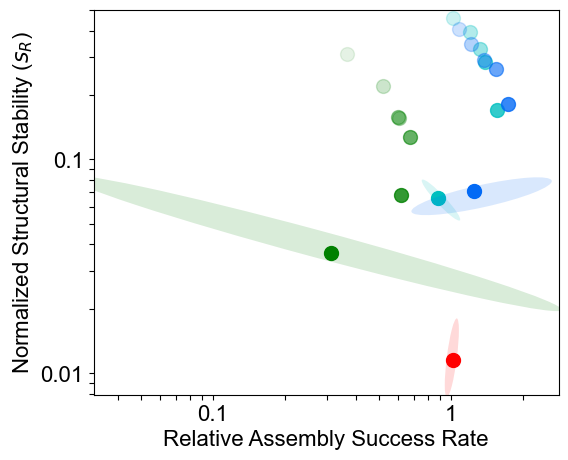

In [6]:
from matplotlib.patches import Ellipse
import matplotlib as mpl

alpha_list = [1, 0.8, 0.6, 0.4, 0.3, 0.2, 0.1]
color_list = ["c", "#036af5", "g", "r"]
keys_list = ["smart_diaux_hwa", "semismart_diaux_hwa", "random_diaux_hwa", "cout_hwa"]
legend_list = ["Sequential - Smart", "Sequential - Top Smart", "Sequential - Random", "Coutilization"]
# color_list = ['b', 'c', 'r']
# keys_list = ["smart_diaux_hwa", "semismart_diaux_hwa", "cout_hwa"]
# legend_list = ["", "", ""]

plt.rcParams["figure.figsize"] = [6, 5]
fig, ax1 = plt.subplots()

feas_list_smart = [i[0] for i in data["smart_diaux_hwa"][0]]
assemb_list_smart = [i[1] for i in data["smart_diaux_hwa"][0]]
struc_stab_list_smart = [i[0] for i in data["smart_diaux_hwa"][1]]
for idx, i in enumerate(assemb_list_smart):
    normalized_assembly = log10(i*8)
    stability = struc_stab_list_smart[idx]
    ax1.scatter(normalized_assembly, stability, marker='o', 
                    s = 100, alpha = alpha_list[idx], color=color_list[0])
    print(normalized_assembly, stability)

feas_list_topsmart = [i[0] for i in data["semismart_diaux_hwa"][0]]
assemb_list_topsmart = [i[1] for i in data["semismart_diaux_hwa"][0]]
struc_stab_list_topsmart = [i[0] for i in data["semismart_diaux_hwa"][1]]
for idx, i in enumerate(assemb_list_topsmart):
    normalized_assembly = log10(i*8)
    stability = struc_stab_list_topsmart[idx]
    ax1.scatter(normalized_assembly, stability, marker='o', 
                    s = 100, alpha = alpha_list[idx], color=color_list[1])
    print(normalized_assembly, stability)

feas_list_random = [i[0] for i in data["random_diaux_hwa"][0]]
assemb_list_random = [i[1] for i in data["random_diaux_hwa"][0]]
struc_stab_list_random = [i[0] for i in data["random_diaux_hwa"][1]]
for idx, i in enumerate(assemb_list_random):
    normalized_assembly = log10(i*8)
    stability = struc_stab_list_random[idx]
    ax1.scatter(normalized_assembly, stability, marker='o', 
                    s = 100, alpha = alpha_list[idx], color=color_list[2])
    print(normalized_assembly, stability)
    
# still have those oval shades
for i, key in enumerate(keys_list):
    x_group, y_group = [log10(i[1]*(2**(index+1))) for index, i in enumerate(data_nolag[key][0])], [i[0] for i in data_nolag[key][1]]
    print(x_group, y_group)
    center = np.mean([x_group, y_group], axis=1)
    cov_matrix = np.cov(x_group, y_group)
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    width, height = 5*np.sqrt(eigenvalues)
    ellipse = Ellipse(center, width, height, angle=angle, facecolor=color_list[i], alpha=0.15)
    ax1.add_patch(ellipse)
    if(key=="cout_hwa"):
        ax1.scatter(x_group[2], y_group[2], marker='o', 
                    s = 100, alpha = 1, color=color_list[3])

xlo, xhi, ylo, yhi = -1.5, 0.45, -2.1, -0.3
ax1.set_xlim(xlo, xhi)
ax1.set_ylim(ylo, yhi)
a, b = ticking(xlo, xhi)
ax1.set_xticks(a, b)
a, b = ticking(ylo, yhi)
ax1.set_yticks(a, b)
# ax1.set_xticks([-1, -0.5, 0], ["$10^{-1}$", "$10^{-0.5}$", "$10^0$"])
# ax1.set_yticks([-1, -1.5, -2], ["$10^{-1}$", "$10^{-1.5}$", "$10^{-2}$"])
# plt.legend()
ax1.set_xlabel("Relative Assembly Success Rate")
ax1.set_ylabel("Normalized Structural Stability ($s_R$)")
plt.savefig("figs/div_vs_stability_4_strategies_lag.pdf",bbox_inches = 'tight')

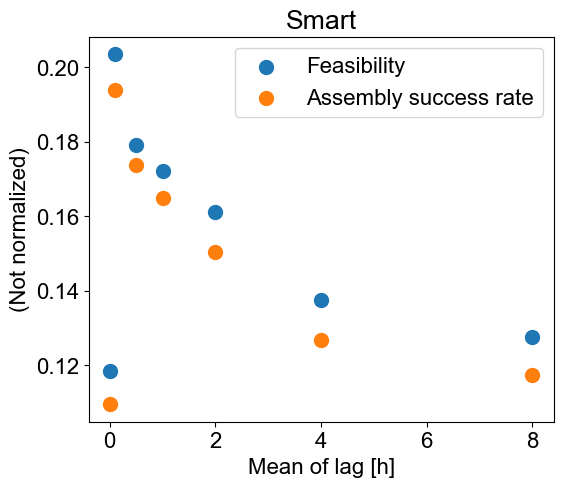

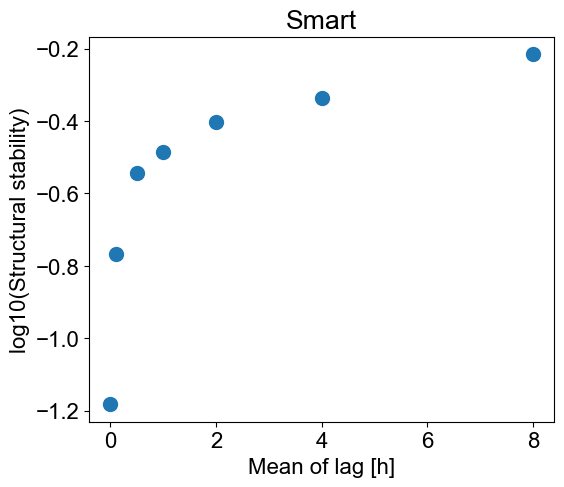

In [59]:
c_tau_list = [0, 0.1, 0.5, 1, 2, 4, 8]
xs = c_tau_list

plt.scatter(xs, feas_list_smart, s=100, label = "Feasibility")
plt.scatter(xs, assemb_list_smart, s=100, label = "Assembly success rate")
plt.legend()
plt.xlabel("Mean of lag [h]")
plt.ylabel("(Not normalized)")
plt.title("Smart")
plt.show()

plt.scatter(xs, struc_stab_list_smart, s=100)
plt.xlabel("Mean of lag [h]")
plt.ylabel("log10(Structural stability)")
plt.title("Smart")
plt.show()

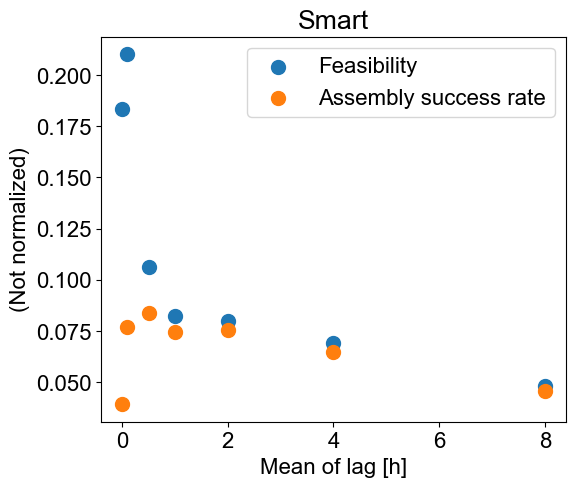

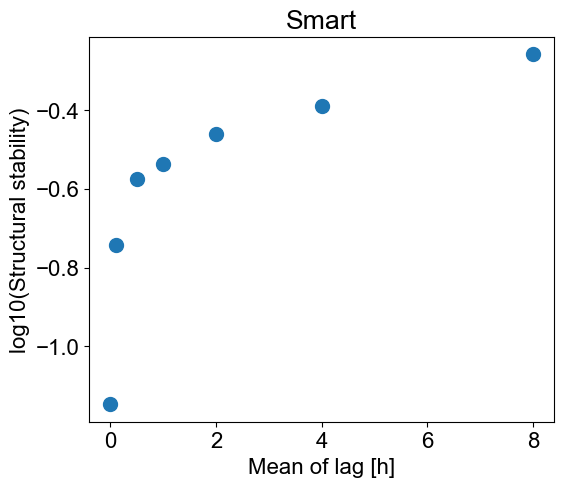

In [61]:
plt.scatter(xs, feas_list_random, s=100, label = "Feasibility")
plt.scatter(xs, assemb_list_random, s=100, label = "Assembly success rate")
plt.legend()
plt.xlabel("Mean of lag [h]")
plt.ylabel("(Not normalized)")
plt.title("Smart")
plt.show()

plt.scatter(xs, struc_stab_list_topsmart, s=100)
plt.xlabel("Mean of lag [h]")
plt.ylabel("log10(Structural stability)")
plt.title("Smart")
plt.show()

In [19]:
log(0.1)/10

-0.23025850929940456

In [26]:
logD, gC = log(100), 1.5
rho_list = [0.20685342671335671, 0.21360680340170085, 0.22771385692846424, 0.235967983991996, 0.239719859929965]
N_community = 1000
MIN_RHO=1e-200
data = []
k = 5
R = 4
rho = rho_list[R-2]
N = R
communities = []
stabilities = []
for i in tqdm(range(N_community)):
    community = {}
    g_enz = generate_g(N, R)
    rhos = rho * np.ones(N)
    rho_expand = np.tile(rhos, (R, 1))
    g_real = 1/(1/(g_enz*(rho_expand+(1-rho_expand)*R))+1/gC)
    pref_list = smart_preference_list(g_real)
    dep_orders = allowed_orders(pref_list)
    taus = np.array([-k*log(max(rho, MIN_RHO))*(np.ones([R, R])-np.eye(R)) for idx in range(N)])
    N_dep_order = len(dep_orders)
    community["g"], community["pref_list"], community["taus"] = g_enz, pref_list, taus
    community["N_dep_orders"] = N_dep_order # allowed number of depletion orders, regardless of growth rates
    community["allowed_orders"] = dep_orders
    community["possible_orders"] = []
    community["possible_steady_state"] = []
    for j in range(N_dep_order):
        dep_order = dep_orders[j]
        RE = resource_eating(pref_list, dep_order)
        G = G_mat_diaux_hwa(g_enz, gC, pref_list, dep_order, rhos)
        if(np.linalg.matrix_rank(G)>=N):
            tau_mod = tau_gtoG(taus, pref_list, dep_order)
            converged, t_iter, S, tau_mod = tsolve_iter(G, RE, taus, tau_mod, logD)
            if(converged == 1 and sum(t_iter>0) >= len(t_iter)):
                community["possible_orders"].append(dep_order)
                community["possible_steady_state"].append([t_iter, S, tau_mod])
    communities.append(community)

100%|██████████| 1000/1000 [00:03<00:00, 300.76it/s]


In [28]:
feasible, stable = 0, 0
N, R = 4, 4
rho = rho_list[R-2]
for index, item in enumerate(communities[:N_community]):
    if(item["possible_orders"]!=[]):
        dep_order = item["possible_orders"][0]
        g, pref_list, taus = item["g"], item["pref_list"], item["taus"]
        t_iter, S, tau_mod = item["possible_steady_state"][0]
        G = G_mat_diaux_hwa(g, gC, pref_list, dep_order, rho*np.ones(N))
        F = F_mat_lag(g, gC, pref_list, dep_order, rho*np.ones(N), logD, N, R, taus)
        env = {"N":N, "R":R, "logD":logD}
        feasible += 1
        print(pref_list)
        print(dep_order)
        if(feasible==1):
            break

print(feasible/N_community)

[[2 4 3 1]
 [1 3 2 4]
 [1 4 3 2]
 [2 4 3 1]]
(1, 2, 3, 4)
0.001


In [29]:
RE = resource_eating(pref_list, dep_order)
tau_mod = tau_gtoG(taus, pref_list, dep_order)
converged, t_iter, S, tau_mod = tsolve_iter(G, RE, taus, tau_mod, logD)
t_iter

array([ 0.43580289,  0.53928986, 10.83252825,  0.02200001])

In [5]:
def tsolve_iter(G, RE, taus, tau_mod, logD):
    # species-niche growth state S
    N, R = taus.shape[0], taus.shape[1]
    S = np.ones([N, R])
    # make the modifications in the first iteration
    converged = 0
    t_iter_compare = np.zeros(R)
    for count in range(10):
        rhs = logD + np.diag( (G*(S>0)) @np.transpose(tau_mod))
        if(np.linalg.matrix_rank(G*(S>0))>=N):
        # if(1):
            t_iter = np.linalg.inv(G*(S>0))@rhs
            S, tau_mod = niche_growth_state(RE, taus, t_iter)
            if ((t_iter_compare==t_iter).all() and np.sum(t_iter)<=24):
                converged = 1
                break
            t_iter_compare = t_iter
        else:
            converged = 0
            break
    return converged, t_iter, S, tau_mod

In [30]:
g

array([[0.92541365, 1.06488825, 0.97770747, 1.00782085],
       [1.42786601, 0.98516001, 1.00354927, 0.90583581],
       [1.19515542, 0.58387144, 0.77690605, 1.00312961],
       [0.65833714, 1.4067126 , 0.92299298, 0.93839168]])